In this notebook, I perform exploratory data analysis on Yosemite's monthly recreational visitor count from 1979 to 2020. Stats were taken from the following website.<br/>

https://irma.nps.gov/STATS/Reports/Park/YOSE<br/>

My end goal is to utilize this visitor data to create a time series model to predict the amount of visitors that will show up to Yosemite in the future.

# Table of Contents
1. [Imports](#section1)
2. [Load in Data](#section2)
3. [Data Cleaning](#section3)
4. [EDA](#section4)
5. [Time Series Exploration](#section5)

<a id='section1'></a>

### 1. Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns
import pickle

In [2]:
# timeseries and eda
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# test if time series is stationary
from statsmodels.tsa.stattools import adfuller, kpss

# autocorrelation and partial autocorrleation
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time series smoothening
from statsmodels.nonparametric.smoothers_lowess import lowess

# auto_arima function identifies the most optimal parameters for an ARIMA model and returns a fitted ARIMA model
from pmdarima import auto_arima

# evaluate model on different metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

<a id='section2'></a>

### 2. Load in Data

In [10]:
park_df = pd.read_csv('data/yosemite_visits.csv', header=0, index_col=0)
park_df.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
Year,,,,,,,,,,,,
1979,72701,72926,87950,136275,210756,301727,379640,427454.0,293424.0,193825.0,99485.0,74619.0
1980,66677,75612,99896,120970,212971,309470,416583,470491.0,289108.0,238586.0,118024.0,71894.0
1981,60669,90274,83104,152469,282531,337392,404269,438123.0,313946.0,190612.0,95862.0,67642.0
1982,60817,68307,70702,73259,254169,363303,425198,432776.0,303673.0,206821.0,85193.0,71369.0
1983,64748,64554,85104,90376,214870,266832,441436,473638.0,350841.0,242778.0,87561.0,74726.0


<a id='section3'></a>

### 3. Data Cleaning

My visitor data currently has year as the index and month as the column. I want have each row represent one month per year. For example, the first row would show visitor counts for January 1979, the second row would show visitor counts for February 1979, etc.

In [11]:
# Stack the visitor counts in monthly columns into their individual rows
park_df = pd.DataFrame(park_df.stack(dropna=True), columns=["num_visitors"])

# Change the date information in index to a datetime object
park_df.index = [(str(idx[0]) + " " + idx[1]) for idx in park_df.index]
park_df.index = pd.to_datetime(park_df.index, format="%Y %b")

# drop rows where number of visitors is zero
park_df.drop(park_df.tail(5).index, inplace=True)

#park_df.to_pickle('data/park_df.pickle')

park_df.head()

,num_visitors
1979-01-01,72701.0
1979-02-01,72926.0
1979-03-01,87950.0
1979-04-01,136275.0
1979-05-01,210756.0


<a id='section4'></a>

### 4. EDA

In [ ]:
park_df = pd.read_pickle('data/park_df.pickle')

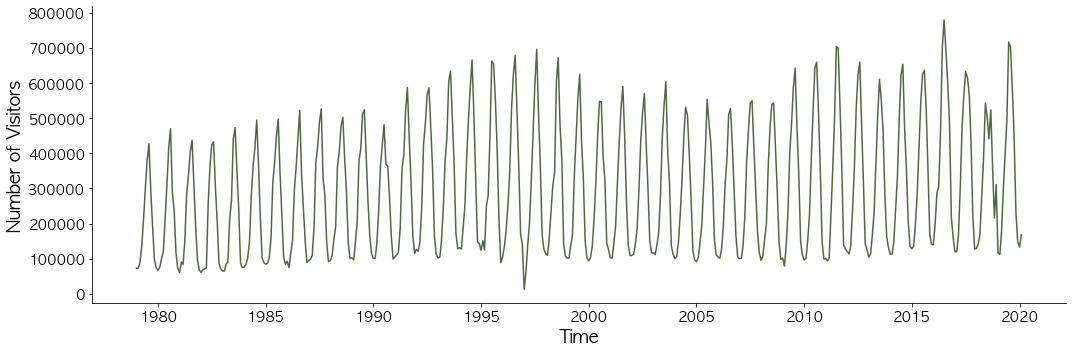

In [13]:
# plot of yosemite recreational visitors over time
plt.figure(figsize=(15,5))
sns.lineplot(park_df.index, park_df["num_visitors"], color="#4B6B3C")
sns.despine(top=True, right=True)

plt.xlabel("Time", fontsize=18, fontname="AppleGothic")
plt.ylabel("Number of Visitors", fontsize=18, fontname="AppleGothic")

plt.xticks(fontsize=14, fontname="AppleGothic")
plt.yticks(fontsize=14, fontname="AppleGothic")

plt.tight_layout()
plt.savefig(f'images/raw_yosemite_visitors.png', format='png', dpi=400, transparent=True);

In [15]:
# Look at yearly and monthly trends
year_df = park_df.copy()
year_df['year'] = year_df.index.year
year_df['month'] = year_df.index.month
years = year_df['year'].unique()

In [16]:
# prepare colors
np.random.seed(100)
mycolors = np.random.choice(list(colors.XKCD_COLORS.keys()), len(years), replace=False)

Plot the number of visitors for each year. The line charts doesn't look good because there are way too many lines. It looks like there's a strong peak of visitors in summer months and visitation decreases in the winter months.

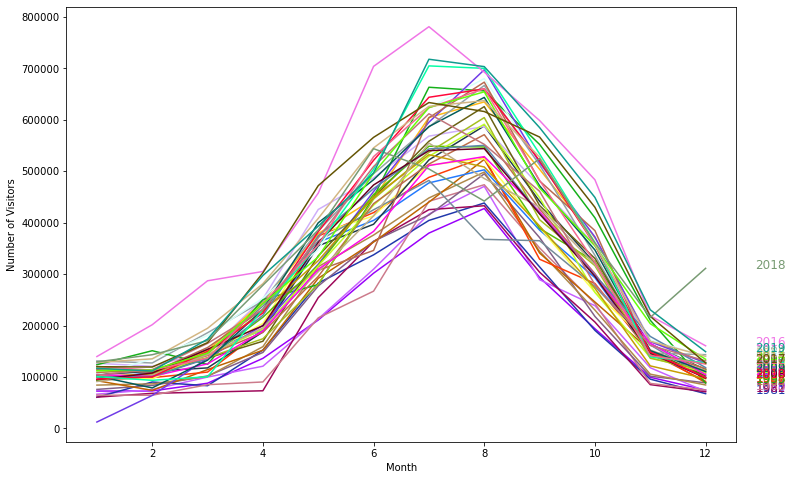

In [17]:
plt.figure(figsize=(12, 8))

for i, y in enumerate(years):
    if y != 2020:
        plt.plot('month', 'num_visitors', data=year_df.loc[year_df['year'] == y, :], color=mycolors[i], label=y)
        plt.text(year_df.loc[year_df.year == y, :].shape[0] + 0.9, 
                 year_df.loc[year_df.year == y, 'num_visitors'][-1:].values[0],
                 y, fontsize=12, color=mycolors[i])
        plt.xlabel("Month")
        plt.ylabel("Number of Visitors");

Boxplots may be a better way to show this data. I can show month-wise (seasonal) and year-wise (annual) trend distributions.

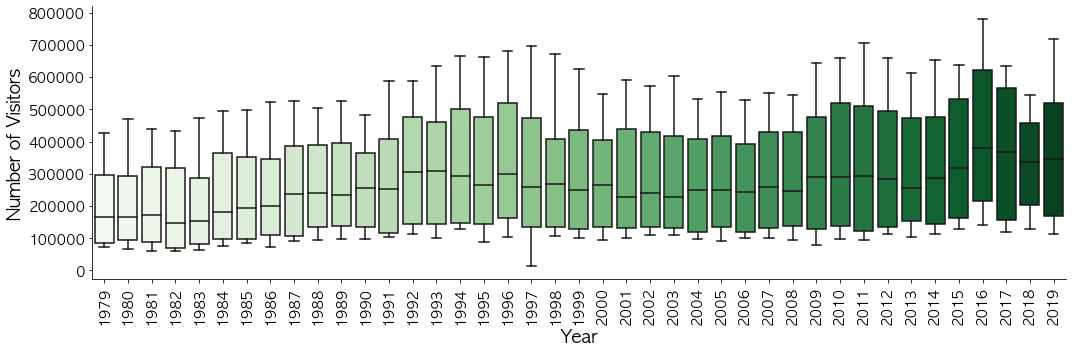

In [83]:
# exclude the year 2020 because there's incomplete data
year_df_graphing = year_df.iloc[:492,:].copy()

plt.figure(figsize=(15, 5))
sns.boxplot(x='year', y='num_visitors', data=year_df_graphing, palette='Greens')
sns.despine(top=True, right=True)

plt.xlabel("Year", fontsize=18, fontname="AppleGothic")
plt.ylabel("Number of Visitors", fontsize=18, fontname="AppleGothic")

plt.xticks(rotation=90, fontsize=14, fontname="AppleGothic")
plt.yticks(fontsize=14, fontname="AppleGothic")

plt.tight_layout()
plt.savefig(f'images/yearly_yosemite_visitors.png', format='png', dpi=400, transparent=True);

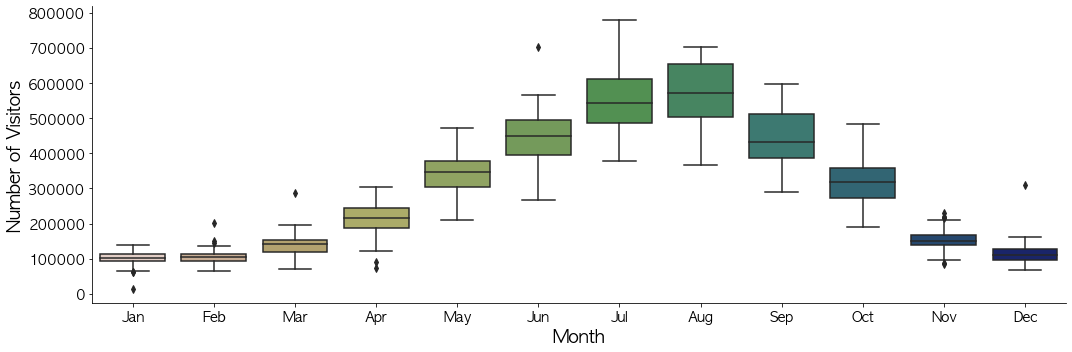

In [90]:
# repeat the above graph, but look at the monthly rather than yearly distribution
plt.figure(figsize=(15, 5))
sns.boxplot(x='month', y='num_visitors', data=year_df_graphing, palette='gist_earth_r')
sns.despine(top=True, right=True)

plt.xlabel("Month", fontsize=18, fontname="AppleGothic")
plt.ylabel("Number of Visitors", fontsize=18, fontname="AppleGothic")

tick_names = [0,1,2,3,4,5,6,7,8,9,10,11]
tick_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.xticks(ticks=tick_names, labels=tick_labels, fontsize=14, fontname="AppleGothic")
plt.yticks(fontsize=14, fontname="AppleGothic")

plt.tight_layout()
plt.savefig(f'images/monthly_yosemite_visitors.png', format='png', dpi=400, transparent=True);

My data is more seasonal and doesn't show much of a trend. One reason there isn't much of a trend is potentially because national parks put a "cap" on the number of visitors that can show up. For example, campers have to make reservations and there's only a limited number of spots for lodging in Yosemite.

<a id='section5'></a>

### 5. Time Series Exploration

Exploring time series with my Yosemite visitor data. What does the seasonal decomposition look like for an additive vs a multiplicative time series model?

* Additive time series:
* Values = Base Level + Trend + Seasonality + Error


* Multiplicative time series:
* Values = Base Level * Trend * Seasonality * Error

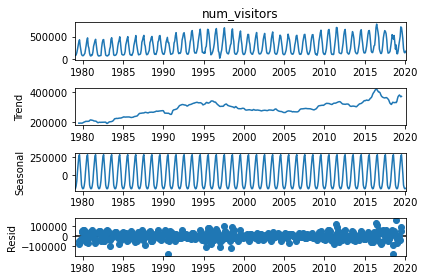

In [20]:
# Seasonal decomposition using moving averages and an additive model
seasonal_add = seasonal_decompose(park_df["num_visitors"], model='additive')
seasonal_add.plot();

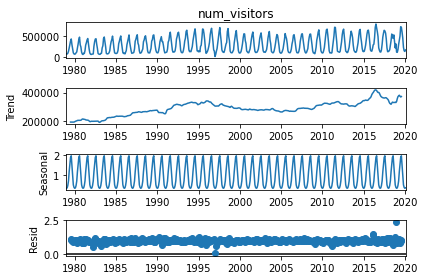

In [21]:
# Seasonal decomposition using moving averages and a multiplicative model
seasonal_mult = seasonal_decompose(park_df["num_visitors"], model='multiplicative')
seasonal_mult.plot();

Trying out ARIMA Modeling. <br/>
What is ARIMA? ARIMA is an autoregressive integrated moving average model. There are 3 order parameters:
* p (autoregression): refers to the use of past values
* d (integration): uses differences in observations from past values
* q (moving average): depicts the error of the model as a combination of previous error terms

There are three different types of ARIMA models:
* ARIMA
* SARIMA (seasonal ARIMA)
* SARIMAX( seasonal ARIMA with exogenous variables)

Following the steps listed here: https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

In [94]:
stepwise_fit = auto_arima(park_df["num_visitors"], 
                          start_p = 1, max_p = 13,
                          start_q = 1, max_q = 13,
                          m = 12,
                          seasonal=True,
                          d = None, D=1, trace=True,
                          error_action = 'ignore', suppress_warnings= True, # don't want convergence warnings
                          stepwise= True) # set to stepwise
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=11511.308, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11697.409, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11533.930, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11545.471, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11700.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=11509.308, Time=0.44 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=11612.015, Time=0.13 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=11511.242, Time=1.01 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=11535.676, Time=0.39 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=11512.391, Time=2.46 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=11506.854, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11610.153, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=11508.846, Time=0.40 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=11508.777, Time=0.63 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  494
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -5749.427
Date:                              Tue, 01 Sep 2020   AIC                          11506.854
Time:                                      17:09:34   BIC                          11523.566
Sample:                                           0   HQIC                         11513.422
                                              - 494                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2675.1236    868.495      3.080      0.002     972.905    4377.342
ar.L1          0.6004      0.031     19.538      0.000       0.540       0.661
ma.S.L12      -0.6090      0.035    -17.162      0.000      -0.679      -0.539
sigma2      1.672e+09      0.000   3.97e+12      0.000    1.67e+09    1.67e+09
===================================================================================
Ljung-Box (Q):                       90.58   Jarque-Bera (JB):               232.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.12e+28. Standard errors may be unstable.
"""

In [105]:
# use the parameters to fit an ARIMA model; set one year (12 months) aside as the test set
train = park_df.iloc[:len(park_df)-12]
test = park_df.iloc[len(park_df) -12:]

# fit a SARIMAX(1, 0, 0)x(0, 1, [1], 12) on the training set
sarimax = SARIMAX(train["num_visitors"],
                  order = (1, 0, 0),
                  seasonal_order = (0, 1, 1, 12),
                 )

sarimax_result = sarimax.fit()
sarimax_result.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         num_visitors   No. Observations:                  482
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -5591.904
Date:                              Tue, 01 Sep 2020   AIC                          11189.808
Time:                                      17:19:11   BIC                          11202.266
Sample:                                  01-01-1979   HQIC                         11194.709
                                       - 02-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5948      0.029     20.728      0.000       0.539       0.651
ma.S.L12      -0.4704      0.037    -12.805      0.000      -0.542      -0.398
sigma2      1.442e+09   2.17e-12   6.66e+20      0.000    1.44e+09    1.44e+09
===================================================================================
Ljung-Box (Q):                       76.66   Jarque-Bera (JB):               225.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.1e+36. Standard errors may be unstable.
"""

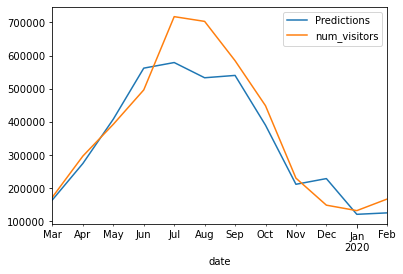

In [106]:
# plot ARIMA model predictions against the test set
start = len(train)
end = len(train) + len(test) - 1

predictions = sarimax_result.predict(start, end, typ='levels').rename("Predictions")
predictions.plot(legend=True)
test["num_visitors"].plot(legend=True);

In [108]:
# evaluate the model with MSE and RMSE
rmse(test["num_visitors"], predictions)

74816.12986657786

In [109]:
mean_squared_error(test["num_visitors"], predictions)

5597453288.212644

The model looks okay. The root mean squared error is around 74,000 people, which is still quite a bit. I don't know if this metric is one I should be using to judge all national parks because some national parks could have many more visitors than others. I'll need to explore other metrics (potentially a percent based metric).

In [110]:
# forecast using the ARIMA model
forecast_model = SARIMAX(park_df["num_visitors"],
                         order = (1, 0, 0),
                         seasonal_order = (0, 1, 1, 12),
                        )
forecast_result = forecast_model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [112]:
# predict for the next 3 years
forecast = forecast_result.predict(start = len(park_df),
                                   end = (len(park_df)-1) + 3*12,
                                   typ='levels').rename('Forecast')

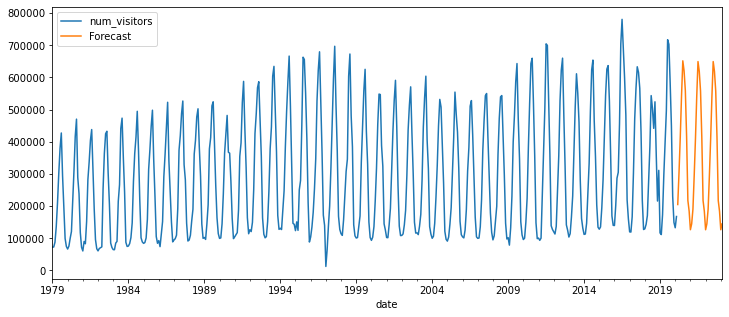

In [113]:
# plot the forecasted values
park_df["num_visitors"].plot(figsize=(12,5), legend=True)
forecast.plot(legend=True);

Next, I'll be following: https://www.machinelearningplus.com/time-series/time-series-analysis-python/ <br/>
A stationary series is one where the values of a series are not a function of time. Properties of that series including mean and variance are constant over time. Many forecasting models are designed to work on stationary time series data.

Why make a non-stationary time series dataset stationary?
* forecasting a stationary series is easier and the forecast is more reliable
* autoregressive forecasting models are basically linear regression models that use the lag of the series as a predictor
* since one of the assumptions of linear regression is that the features are independent, the goal is to remove this correlation by making a time series stationary

I'll use the ADF (Augmented Dickey Fuller) test to check if data is stationary. The null hypothesis is the time series possess a unit root and is non-stationary.

In [52]:
result = adfuller(park_df["num_visitors"], autolag='AIC')
print(f'ADF Statistics: {result[0]}')
print(f'p_value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'    {key}, {value}')

ADF Statistics: -1.5746812726059634
p_value: 0.49629821847685684
Critical Values:
    1%, -3.4441047380903007
Critical Values:
    5%, -2.867605550172837
Critical Values:
    10%, -2.570000704119326


Because the p-value is around 0.5, I cannot reject the null hypothesis. It's likely that my time series possess a unit root and is non-stationary.

The next test I'll use is the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test. The null hypothesis is the opposite of the ADF test. The null hypothesis states the time series doesn't possess a unit root and is stationary.

In [55]:
result = kpss(park_df["num_visitors"], regression='c', nlags='auto')
print(f'KPSS Statistic: {result[0]}')
print(f'p_value: {result[1]}')
for key, value in result[3].items():
    print('Critical Values:')
    print(f'    {key}, {value}')

KPSS Statistic: 2.0488241283400894
p_value: 0.01
Critical Values:
    10%, 0.347
Critical Values:
    5%, 0.463
Critical Values:
    2.5%, 0.574
Critical Values:
    1%, 0.739


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Because the p-value is less than 0.05, I can reject the null hypothesis. It's likely that my time series does possess a unit root and is non-stationary.

Next, I want to examine autocorrelation and partial autocorrelation.<br/>
Correlation is defined as how an increase or decrease in one variable affects another variable to increase or decrease.
Autocorrelation is correlation of a current value with the previous values (with a lag).<br/>
Partial autocorrelation is looking at the correlation between a value and a value with lag without taking the correlation of values in between. For example, look at the value for last Sunday. The value with lag could be last Thursday. Then, with partial autocorrelation, the values from last Monday through Wednesday would not be taken into consideration.

In [58]:
# look at autocorrelation
park_acf = acf(park_df['num_visitors'], fft=False)
park_acf

array([ 1.        ,  0.83912456,  0.48388684,  0.03435198, -0.38453187,
       -0.66326081, -0.76106135, -0.65669343, -0.37914783,  0.02881636,
        0.46823304,  0.80536044,  0.94184671,  0.80289294,  0.46444635,
        0.02708534, -0.37807952, -0.65228126, -0.75217854, -0.65347717,
       -0.38187575,  0.01792948,  0.44953763,  0.78530784,  0.91851606,
        0.77963977,  0.45066816,  0.02177454, -0.37818409, -0.6454523 ,
       -0.74105801, -0.64734798, -0.38144537,  0.01194157,  0.43207784,
        0.75639363,  0.88769665,  0.75642541,  0.43195442,  0.01439931,
       -0.37359701])

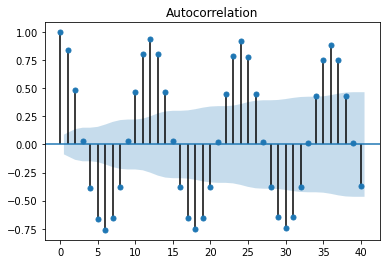

In [68]:
# the confidence interval is drawn as a cone when the lag is 40
plot_acf(park_df['num_visitors'].tolist(), lags=40);

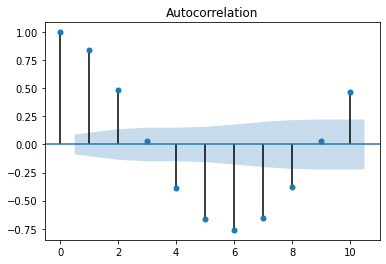

In [72]:
# the confidence interval is drawn as a cone when the lag is 10
plot_acf(park_df['num_visitors'].tolist(), lags=10);

In [61]:
# examine partial autocorrelation
park_pacf = pacf(park_df['num_visitors'])
park_pacf

array([ 1.00000000e+00,  8.40826638e-01, -7.54701729e-01, -3.78162751e-01,
       -1.40941387e-01, -8.17694180e-03, -1.80079711e-01,  4.88319631e-02,
        1.74315226e-01,  4.85652493e-01,  4.92091182e-01,  3.63310154e-01,
        3.71289684e-01, -2.24686797e-01,  1.26448674e-04, -8.46331821e-02,
        5.42243219e-02, -8.32827485e-02, -1.53293166e-01, -1.25511680e-01,
       -4.82217611e-02,  9.15728275e-02,  1.75402312e-01,  2.98394147e-01,
        2.30954831e-01, -2.05721302e-01,  3.28714974e-02, -1.02712853e-01,
       -1.16463035e-01, -1.09219984e-01, -1.05331677e-01, -1.94931655e-01,
       -2.41115653e-02,  1.40296900e-01,  1.45361061e-01,  1.78390325e-01,
        3.04749576e-01,  8.17497084e-02, -7.99421056e-02, -1.62225068e-01,
       -2.59067117e-01])

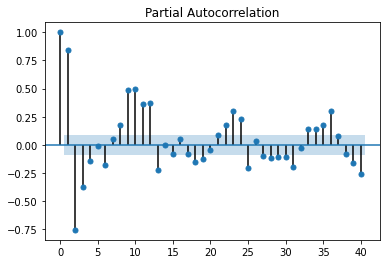

In [62]:
plot_pacf(park_df['num_visitors'].tolist(), lags=40);

A lag plot is a scatter plot of a time series against a lag of itself. It's used to check for autocorrelation. If there's a pattern, then the series may be autocorrelated. If not, the series may just be random noise.

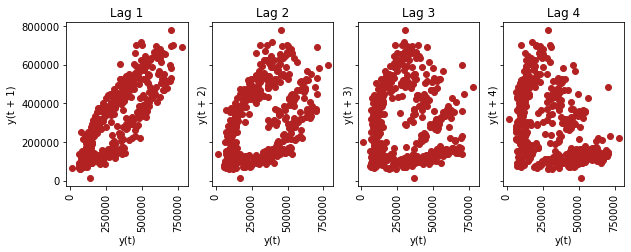

In [116]:
# if the points get wide and scatter with increasing lag, that means there's less correlation
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()[:4]):
    pd.plotting.lag_plot(park_df['num_visitors'], lag=i+1, ax=ax, c='firebrick')
    
    ax.tick_params(axis='x', labelrotation=90)
    
    ax.set_title('Lag ' + str(i+1));

Looks like there's a pattern with a lag of 1, potentially a pattern with lags 2 and 3, and more random noise with lag of 4.

Testing out how to smoothen a time series. Why smoothen a time series?
* reduce the effect of noise
* visualize the trend better
* smoothened version can be used as a feature to explain the original series

Utilize LOESS (localized regression) to smoothen the series. What it does is fit multiple regressions in the local neighborhood of each point.

In [107]:
# calculate a moving average for every 12 months to nullify the seasonal pattern
moving_avg = park_df['num_visitors'].rolling(12, center=True, closed='both').mean()

In [108]:
# Try different Loess Smoothing patterns (5% and 10%)
loess_5 = lowess(park_df['num_visitors'], np.arange(len(park_df['num_visitors'])), frac=0.05)[:,1]
loess_15 = lowess(park_df['num_visitors'], np.arange(len(park_df['num_visitors'])), frac=0.15)[:,1]

df_loess_5 = pd.DataFrame(loess_5, index=park_df.index, columns=['value'])
df_loess_15 = pd.DataFrame(loess_15, index=park_df.index, columns=['value'])

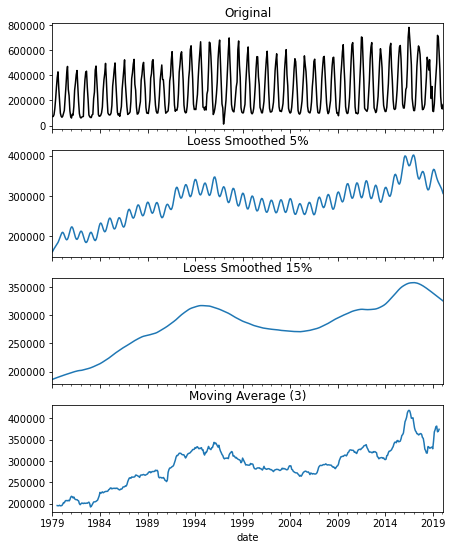

In [109]:
# plot with a shared x axis
fig, axes= plt.subplots(4, 1, figsize=(7,9), sharex=True)
park_df_df['num_visitors'].plot(ax=axes[0], color='k', title='Original')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
moving_avg.plot(ax=axes[3], title='Moving Average (12)')
plt.show();

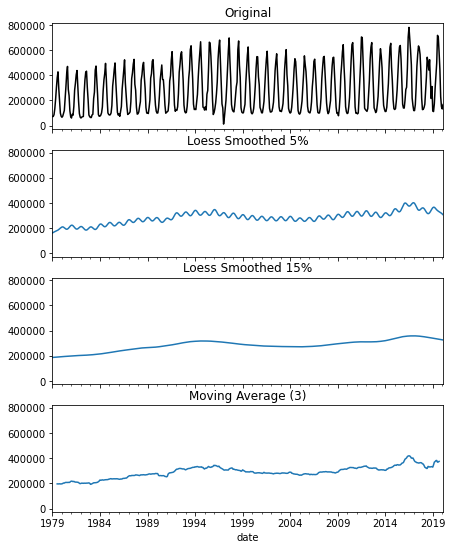

In [110]:
# plot with a shared x and y axis
fig, axes= plt.subplots(4, 1, figsize=(7,9), sharex=True, sharey=True)
park_df_df['num_visitors'].plot(ax=axes[0], color='k', title='Original')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
moving_avg.plot(ax=axes[3], title='Moving Average (12)')
plt.show();